# Sudoku AI Solver
---
- Bộ giải câu đố Trí tuệ nhân tạo Sudoku (Suduku AI Solver) được xây dựng bằng các phương pháp: Python, OpenCV, Deep Learning và Nhận dạng ký tự quang học (OCR) để giải câu đố thu được từ hình ảnh.
- Các bước cần thiết để triển khai bộ giải sẽ được trình bày sau phần tổng quan ngắn gọn về  câu đố Sudoku.


## 1. Sodoku
---
- Sudoku, ban đầu có tên gọi là Number Place là một trò chơi câu đố sắp xếp chữ số dựa trên logic theo tổ hợp.
- Mục tiêu của trò chơi là điền các chữ số vào một lưới 9×9 sao cho mỗi cột, mỗi hàng, và mỗi phần trong số chín lưới con 3×3 cấu tạo nên lưới chính đều chứa tất cả các chữ số từ 1 tới 9.
- Mỗi câu đố chứa các số được điền sẵn cùng với các ô/khoảng trắng trống để điền vào theo các quy tắc Sudoku.
- Dưới đây là một ví dụ về câu đố sudoku điển hình.

<img src='images/sodoku1.png'>

## 2. Các bước giải
---
<img src='images/sodoku.jpg'>

- Trình giải sudoku AI bắt đầu bằng cách chấp nhận hình ảnh đầu vào có chứa câu đố sudoku.
- Tiếp theo, OpenCV được áp dụng để định vị và trích xuất bảng sudoku từ hình ảnh.
- Sau đó, mỗi ô của bảng được định vị rồi kiểm tra các chữ số trong đó. Nếu có một chữ số, mô hình Deep Learning được đào tạo về Nhận dạng ký tự quang học (OCR) sẽ được sử dụng để nhận dạng nó.
- Lúc này, với vị trí và chữ số của ô, một tập lệnh python sẽ được chạy để giải câu đố sudoku.
- Cuối cùng, câu đố đã giải sẽ được hiển thị dưới dạng hình ảnh cho người dùng.

---
- Hầu hết các bước này có thể được thực hiện bằng OpenCV, tuy nhiên, việc đào tạo mô hình OCR liên quan đến việc sử dụng thư viện Keras và Tensorflow. Các gói, thư viện và framework được sử dụng trong dự án này được liệt kê dưới đây:

    - OpenCV - Thư viện mã nguồn mở cung cấp các công cụ, chức năng và phần cứng thị giác máy tính theo thời gian thực.
    - JupyterLab - Môi trường phát triển tương tác dựa trên web dành cho sổ ghi chép, mã và dữ liệu.
    - Tensorflow - Thư viện Trí tuệ nhân tạo được sử dụng để xây dựng, đào tạo và triển khai các mô hình Machine Learning và Deep Learning.
    - Keras - Thư viện Deep Learning cung cấp giao diện cho Tensorflow.
    - Numpy - Thư viện Python được sử dụng để thao tác và tính toán mảng đa chiều, đại số tuyến tính cơ bản, các phép toán thống kê, v.v. Nó được OpenCV sử dụng cho các hoạt động mảng.
    - Matplotlib - Thư viện được sử dụng để trực quan hóa bằng Python.
    - Scikit-image - Thư viện được sử dụng để xử lý hình ảnh bằng Python.
    - Scikit-learn - Thư viện được sử dụng cho Machine Learning trong Python.
    - Imutils - Gói Python được sử dụng cho các hoạt động xử lý ảnh cơ bản.
    - Pytest - Framework thử nghiệm Python dùng để viết bài test cho các ứng dụng và thư viện.

In [1]:
# Bỏ qua loại Cảnh báo của TensorFlow

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [2]:
# Import các thư viện
import cv2
import imutils
import copy
import numpy as np
import matplotlib.pyplot as plt
from keras.models import load_model
from tensorflow.keras.preprocessing.image import img_to_array
from solve_sudoku import *
from imutils.perspective import four_point_transform
from skimage.segmentation import clear_border

## 2.1 Hiển thị hình ảnh và trích xuất câu đố sudoku
---
### 2.1.1 Hàm hiển thị ảnh: 
+ Đọc ảnh bằng OpenCV
+ Hiển thị ảnh với tiêu đề cho trước

In [3]:
def display_img(img, title):
    """
    Hàm hiển thị ảnh với tiêu đề
    """
    #Đọc ảnh
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    #Hiển thị ảnh
    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(111)
    ax.set_title(title, fontsize=22)
    ax.imshow(img,cmap='gray')

### 2.1.2 Hàm trích xuất phần câu đố Sodoku từ ảnh đầu vào:
#### 1. Chuyển ảnh màu RGB thành ảnh xám
---
#### 2. Làm mịn ảnh(lọc nhiễu) bằng phương pháp Gaussian
- Đây là một trong những phương pháp làm mịn hữu ích.Lọc Gaussian được thực hiện bằng cách xoay từng điểm trong mảng đầu vào với một hạt nhân Gaussian và sau đó tổng hợp tất cả chúng để tạo ra mảng đầu ra.

    - **`cv2.GaussianBlur(src, kernel,sigmaX, sigmaY)`**

    - Ý nghĩa các tham số:

        - 1. `src`: ảnh gốc cần thay đổi kích thước.
        - 2. `kernel (width, height)`: Kích thước cửa sổ trượt, phải là số dương và lẻ.

- Xem thêm thông tin về smoothing trong OpenCV:  https://docs.opencv.org/3.4/dc/dd3/tutorial_gausian_median_blur_bilateral_filter.html
---
#### 3. Áp dụng ngưỡng thích nghi(Adaptive thresholding)
- Phương pháp phân ngưỡng toàn cục không phù hợp cho nhiều trường hợp như là với trường hợp ánh sáng không đồng đều trên ảnh. Khi đó phân ngưỡng thích nghi là một giải pháp.

- OpenCV cung cấp phương thức adaptiveThreshold để thực hiện phân ngưỡng thích nghi. Phương thức này sẽ tính giá trị trung bình của n điểm ảnh xung quanh điểm ảnh đó rồi trừ đi C (n là thường là số lẻ, C là một số nguyên bất kỳ)

    - **phương thức adaptiveThreshold của OpenCV:**

    - **`pic = cv2.adaptiveThreshold(img, maxValue,thresholdType, type, n, C)`**
    
    - trong đó:
    
        - `img`: ảnh gốc
        - `maxValue`: giá thiết lập nếu > giá trị ngưỡng
        - `adaptiveMethod`: phương pháp tính cho các điểm lân cận lấy trung bình hay theo Gaussian
            - **ADAPTIVE_THRESH_MEAN_C** − threshold value is the mean of neighborhood area.
            - **ADAPTIVE_THRESH_GAUSSIAN_C** − threshold value is the weighted sum of neighborhood values where weights are a Gaussian window.
        - `type`: Loại xử lý cắt ngưỡng
            - THRESH_BINARY: Có thể dịch là ngưỡng nhị phân. Ý nghĩa y hệt những gì mình đề cập ở trên.
            - THRESH_BINARY_INV: Ngưỡng nhị phân đảo ngược. Có thể hiểu là nó sẽ đảo ngược lại kết quả của THRESH_BINARY.
        - `n`: Số lượng điểm ảnh xung quanh sử dụng để tính giá trị cho điểm đang xét, là số lẻ.
        - `C`: Giá trị số bất kỳ được sử dụng để trừ.
        
<img src='images/thresholded.jpg' width=400px>

---
#### 4. Tìm các đường viền trong hình ảnh có ngưỡng và sắp xếp chúng theo thứ tự giảm dần để xác định đường viền của câu đố sudoku
- Hàm **`cv2.findContours()`** này được sử dụng để truy xuất các đường viền từ hình ảnh được áp dụng ngưỡng thích nghi(thresholded image)
- Một bản sao của thresholded image được chuyển vào hàm với các tham số: CHAIN_APPROX_SIMPLE, một phương pháp gần đúng đường viền mã hóa một đường viền hình chữ nhật có 4 điểm và RETR_EXTERNAL, một phương pháp truy xuất đường viền chỉ truy xuất các đường viền ngoài cùng.

- Gói hàm imutils, grab_contours(), trả về các đường viền thu được ở dòng mã trước đó và các đường viền này sau đó được sắp xếp theo khu vực theo thứ tự ngược/giảm dần. Hai hàm OpenCV cv2.arcLength()và cv2.approxPolyDP(), được sử dụng để xác định đường viền câu đố.
- Đầu tiên, puzzle outline variable, puzzle_cnt, được khởi tạo. Các đường viền được lặp lại để tìm chu vi của đường viền với cv2.arcLength() trong khi cv2.approxPolyDP()trả về một đường viền gần đúng của đường viền được truyền vào. **0,02** chỉ định phương sai tối đa giữa đường viền ban đầu và chu vi của phép tính gần đúng, nghĩa là phép tính gần đúng là 2% của đường viền ban đầu. Nếu đường viền có gần đúng **4** điểm thì coi như đây là đường viền của câu đố.
- Chỉ số đường viền là **-1** và giá trị âm cho biết tất cả các đường viền đều được vẽ, **(0, 255, 0)** là màu đường vẽ (màu xanh lá cây trong trường hợp này) và **3** là độ dày của đường.

<img src='images/puzzle_outline.jpg' width=400px>

- Trước khi chuyển sang định vị và trích xuất các chữ số trong câu đố, cần phải chỉnh thẳng hình ảnh câu đố để sang chế độ nhìn từ trên xuống để dễ xác định hàng, cột và ô của câu đố sudoku. Hoạt động này đạt được bằng cách sử dụng chức năng four_point_transform() từ gói imutils trên cả hình ảnh câu đố màu và ảnh xám:

    **`color_puzzle = four_point_transform(img, puzzle_cnt.reshape(4,2))`** 
    **`gray_puzzle = four_point_transform(gray, puzzle_cnt.reshape(4,2))`** 
- Phương thức này reshape(4,2) định hình lại mảng đường viền câu đố để có hình dạng (4, 2) , định dạng bắt buộc cho hàm four_point_transform(). Hình ảnh bên dưới hiển thị ảnh xám sau khi áp dụng phép biến đổi.

<img src="images/extracted_gray.jpg">

- Hàm find_puzzle() trả về các hình ảnh đã được chuyển đổi color_puzzle và gray_puzzle sẽ được sử dụng trong các bước tiếp theo trong bộ giải AI sudoku như sau:
 
    **`color_puzzle, gray_puzzle = find_puzzle(img, debug=True)`**
    
- Bước tiếp theo trong quá trình giải là khoanh vùng từng ô trong câu đố.

In [4]:
def find_puzzle(img, debug=False):
    """
    Trích xuất phần câu đố sodoku từ ảnh đầu vào
    """
    
    # Chuyển ảnh màu thành ảnh xám và làm mịn bằng Gaussian
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    blurred = cv2.GaussianBlur(gray, (7,7), 3)

    # Áp dụng ngưỡng thích nghi
    thresh = cv2.adaptiveThreshold(blurred, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV, 11, 2)

    # Find contours in the thresholded image and sort them by size in descending order
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sorted(cnts, key=cv2.contourArea, reverse=True)
    
    # Initialize a contour that corresponds to the puzzle outline
    puzzle_cnt = None
    
    # Loop over the contours
    for c in cnts:
        # Approximate the coutour
        peri = cv2.arcLength(c, True)
        approx = cv2.approxPolyDP(c, 0.02 * peri, True)

        # If the approximated contour has 4 points, then it is assumed that 
        # this contour is the puzzle outline
        if len(approx) == 4:
            puzzle_cnt = approx
            break
        
    puzzle_outline = img.copy()
    cv2.drawContours(puzzle_outline, [puzzle_cnt], -1, (0, 255, 0), 3)

    # Apply a four point perspective transform to both the original image and 
    # grayscale image to obtain a top-down bird's eye view of the puzzle
    color_puzzle = four_point_transform(img, puzzle_cnt.reshape(4,2)) 
    gray_puzzle = four_point_transform(gray, puzzle_cnt.reshape(4,2))  
    
    if debug:
        display_img(img, 'Original Image')
        display_img(thresh, 'Thresholded Image')
        display_img(puzzle_outline, 'Puzzle Outline')
        display_img(gray_puzzle, 'Extracted Grayscale Puzzle')
        
    return color_puzzle, gray_puzzle

## 2.2 Định vị từng ô và trích xuất số
---
- Để định vị từng ô, bảng sudoku cần được chia thành các ô riêng lẻ rồi tạo vị trí tọa độ (x,y) của mỗi ô
- Mô hình OCR cũng được tải vì nó sẽ được hàm classify_digit() được gọi từ hàm generate_cell_locations(), sử dụng để phân loại các chữ số.
- Hàm bắt đầu bằng cách khởi tạo một danh sách: cell_locs, để lưu trữ tọa độ (x, y) của từng vị trí ô. 
- Sau đó, nó lặp lại từng vị trí ô của bảng sudoku, từng hàng và nối thêm các giá trị start_x, start_y, end_x, end_y của từng ô vào danh sách.
    - Hình dưới đây minh họa một ô điển hình có tọa độ bắt đầu và kết thúc (x, y).
    <img src='images/sudoku_cell.jpg' width='300px'>

In [5]:
def generate_cell_locations(step_x, step_y):
    """
    Generate (x, y) coordinates for each cell of the sudoku board.
    """

    # Initialize a list to store (x,y) coordinates of each cell location
    cell_locs = []

    # Loop over the grid lcoations
    for y in range(9):
        # Initialize the current list of cell locations
        row = []

        for x in range(9):
            # Compute the starting and ending (x,y) coordinates of the current cell
            start_x = x * step_x
            start_y = y * step_y
            end_x = (x + 1) * step_x
            end_y = (y + 1) * step_y

            # Add the (x,y) coordinates to the cell locations list
            row.append((start_x, start_y, end_x, end_y))

            # Crop the cell from the gray_puzzle transformed image and then extract
            # the digit from the cell
            cell = gray_puzzle[start_y:end_y, start_x:end_x]
            digit = extract_digit(cell)

            # Confirm that the digit is not empty
            if digit is not None:
                classify_digit(digit, x, y)

        # Add the row to the cell locations
        cell_locs.append(row)

    return cell_locs

- Đối với mỗi lần lặp, hàm generate_cell_locations() gọi hàm extract_digit() để xác định xem có chữ số nào có trong ô hiện tại hay không
- Tương tự như việc tìm ra đường viền của câu đố sudoku, kỹ thuật ngưỡng cũng được áp dụng ở đây trong việc trích xuất chữ số. Hàm clear_border(), từ thư viện skimage.segmentation, được sử dụng để xóa mọi đường viền được kết nối chạm vào đường viền ô tương ứng. Bước tiếp theo là tìm đường viền trong ô được ngưỡng, nếu không tìm thấy đường viền nào thì sẽ trả về None. Nếu có đường viền trong cnts, đường viền lớn nhất theo diện tích pixel sẽ được tìm thấy và mặt nạ được tạo cho đường viền đó.

- Việc chia vùng pixel của mặt nạ cho diện tích của chính ô sẽ cho giá trị percentFilled, tức là ô được "lấp đầy" bao nhiêu pixel trắng. Tỷ lệ phần trăm này được sử dụng để xác nhận xem đường viền có bị nhiễu hay có chứa một chữ số hay không; bất kỳ tỷ lệ phần trăm nào nhỏ hơn 3% được coi là chỉ chứa nhiễu.

- Nếu ô không bị nhiễu, mặt nạ sẽ được áp dụng cho thresholded image và chữ số được trả về. Ví dụ, ô được trích ở góc dưới bên trái của câu đố sudoku.jpg được hiển thị bên dưới.
    <img src='images/digit.jpg' width='300px'>

In [6]:
def extract_digit(cell):
    """
    Extracts and returns the digit of the passed in cell. If no digit was identified, the function 
    returns None.
    """
    
    # Apply automatic thresholding to the cell and then clear any connected borders 
    # that touch the border of the cell
    thresh = cv2.threshold(cell, 0, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
    thresh = clear_border(thresh)
    
    # Find contours in the thresholded cell
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    
    # If no contours were found then this is an empty cell
    if len(cnts)==0:
        return None
    
    # Otherwise find the largest contour in the cell and create a mask for the contour
    c = max(cnts, key=cv2.contourArea)
    mask = np.zeros(thresh.shape, dtype="uint8")
    cv2.drawContours(mask, [c], -1, 255, -1)
    
    # Compute the perecentage of masked pixels relative to the total area of the image
    (h, w) = thresh.shape
    percent_filled = cv2.countNonZero(mask) / float(w * h)
    
    # If less than 3% of the mask is filled then we are looking at noise and can safely ignore the contour
    if percent_filled < 0.03:
        return None
    
    # Apply the mask to the thresholded cell
    digit = cv2.bitwise_and(thresh, thresh, mask=mask)

    return digit

- Chữ số trả về sau đó được phân loại bằng classify_digit()
- Chữ số, **roi**, được thay đổi kích thước thành 28x28 pixel -- kích thước của hình ảnh trong bộ dữ liệu MNIST được sử dụng để đào tạo các mô hình học sâu để nhận dạng ký tự quang học. **roi** được xử lý trước khi phương thức predict() được gọi trong model để dự đoán chữ số. Bảng sudoku sau đó được cập nhật với dự đoán này, do đó thay thế giá trị mặc định là 0.

- Hàng hiện tại của bảng được thêm vào danh sách cell_locs và quá trình này tiếp tục cho đến khi tất cả các hàng của bảng sudoku đã được xử lý.

- Sau đây là phần giải thích ngắn gọn quy trình liên quan đến việc xây dựng mô hình deep learning được hàm classify_digit() này sử dụng cho OCR.

In [7]:
def classify_digit(digit, x, y):
    """
    Classifies the passed in digit using the OCR model then assigns the digit to 
    corresponding cell of the unsolved sudoku board.
    """
    
    global unsolved_board
    
    # Resize the cell to 28x28 pixels and prepare it classification 
    # 28x28 is the size of images in the MNIST dataset
    roi = cv2.resize(digit, (28, 28))
    roi = roi.astype("float")/255.0
    roi = img_to_array(roi)
    roi = np.expand_dims(roi, axis=0)

    # Classify the digit and update the sudoku board with the prediction
    pred = model.predict(roi, verbose=0).argmax(axis=1)[0]
    unsolved_board[y, x] = pred

## 2.3 Mô hình Deep Learning để nhận dạng ký tự quang học (OCR)
---
- Deep Learning là một tập hợp con của các kỹ thuật Học máy (Học máy là một tập hợp con của Trí tuệ nhân tạo) sử dụng kiến trúc mạng thần kinh nhân tạo để học từ dữ liệu. Mạng lưới thần kinh là các lớp nút, tương tự như các tế bào thần kinh trong não người, cố gắng mô phỏng khả năng học hỏi của não từ một lượng lớn dữ liệu và đưa ra dự đoán. Các nút trong các lớp riêng lẻ được kết nối với các nút liền kề . Mạng được cho là 'sâu' tùy thuộc vào số lượng lớp ẩn mà nó có. Mạng nơ-ron truyền thống chỉ chứa 2-3 lớp ẩn, trong khi deep network có thể có tới 150 lớp.

- Hình dưới đây cho thấy cách bố trí của một mạng lưới thần kinh điển hình.
<img src='images/neural_network.jpg' >

- Các mô hình học sâu được đào tạo bằng cách sử dụng một tập hợp lớn dữ liệu được gắn nhãn và kiến trúc mạng thần kinh học các tính năng trực tiếp từ dữ liệu mà không cần trích xuất tính năng thủ công. Mạng nơ-ron tích chập (CNN hoặc ConvNet) là một trong những loại mạng nơ-ron sâu phổ biến nhất. CNN kết hợp các tính năng đã học với dữ liệu đầu vào và sử dụng các lớp tích chập 2D, làm cho kiến trúc này rất phù hợp để xử lý dữ liệu 2D, chẳng hạn như hình ảnh.

- CNN hoạt động bằng cách trích xuất các đặc điểm trực tiếp từ hình ảnh. Các tính năng liên quan không được đào tạo trước; chúng được học trong khi mạng đào tạo một bộ sưu tập hình ảnh. Việc trích xuất tính năng tự động này giúp các mô hình deep learning có độ chính xác cao cho các tác vụ thị giác máy tính, chẳng hạn như phân loại đối tượng. Hình dưới đây minh họa quy trình CNN để phân loại các chữ số viết tay.
<img src='images/convnet.jpeg' >

- Để thực hiện nhận dạng ký tự quang học trên các chữ số thu được từ extract_digit(), một mô hình thần kinh tích chập được xây dựng và huấn luyện bằng cách sử dụng bộ dữ liệu MNIST . Bộ dữ liệu MNIST là bộ dữ liệu cổ điển chứa các hình ảnh có kích thước 28x28 pixel gồm các chữ số viết tay, với 60.000 hình ảnh để đào tạo mô hình và 10.000 hình ảnh để thử nghiệm mô hình. Các hình ảnh viết tay có thang độ xám đơn từ 0 đến 9. Một mẫu của những hình ảnh này được hiển thị bên dưới.
<img src='images/MnistExamples.png' >

- Bộ dữ liệu MNIST là một phần của thư viện deep learning Keras nên chỉ cần vào notebook train_digit_classifier.ipynb, trong thư mục model_files, dùng để xây dựng và huấn luyện mô hình deep learning OCR.

- Mô hình được đào tạo, digit_classifier_model.h5, có trong thư mục model_files, được sử dụng để OCR chữ số được trích xuất.

- Mô hình được đào tạo đã phân loại các chữ số được trích xuất từ số trước đó và thay thế chúng vào các ô tương ứng của unsolved_board. Bước tiếp theo là sử dụng solve_sudoku.py để giải câu đố sudoku **unsolved_board**.

## 2.4 Giải câu đố và hiển thị lời giải
---
- Câu đố **unsolved_board** được chuyển đổi thành kiểu dữ liệu list trước khi giải. Việc chuyển đổi này là cần thiết vì solve_sudoku.py được viết để giải câu đố sudoku ở định dạng list chứ không phải là một mảng có nhiều mảng.
- Cuối cùng, tạo 1 bản sao của unsolved_board trước khi chuyển nó vào hàm solve_puzzle() từ solve_sudoku.py, để cho phép các solution được viết (sử dụng display_solutions() chức năng ở dưới) trên hình ảnh câu đố đồng thời tránh các ô đã có sẵn số.
- Để giải câu đố sudoku, đệ quy và quay lui được sử dụng. Đệ quy là một hàm gọi chính nó.
- Backtracking là một kỹ thuật thuật toán để giải các bài toán thỏa mãn ràng buộc một cách đệ quy mà không cần thử tất cả các khả năng. Một số thuật toán sử dụng backtracking bao gồm:

    - N-Queens problem in chess,
    - Traveling salesperson problem,
    - Graph coloring problem, 
    - Sudoku.
- Trong trường hợp giải các câu đố sudoku, những suy đoán hợp lệ để giải câu đố bị hạn chế bởi các quy tắc của trò chơi. Để một số là một phần của tập hợp các dự đoán hợp lệ (hãy nhớ rằng số lần đoán chỉ có thể từ 1 đến 9) để điền vào ô trống trên bảng, số đó không được :

    - đã có ở hàng liên kết của ô trống,
    - đã có trong cột liên kết của ô trống và
    - đã có trong khối 3x3 liên quan của ô trống.
    
- Để giải câu đố sudoku bằng backtracking, hãy bắt đầu với ô trống đầu tiên trên bảng và số đầu tiên trong tập hợp các dự đoán hợp lệ sẽ được chọn để điền vào ô. Ô trống tiếp theo sẽ được xử lý và số đầu tiên trong tập hợp các dự đoán hợp lệ sẽ được chọn để điền vào ô. Nếu đạt đến một ô trống mà không có bất kỳ dự đoán hợp lệ nào, bộ giải sẽ quay lại ô trước đó và chọn lần đoán tiếp theo trong tập hợp các lần đoán hợp lệ và cố gắng tiến về phía trước. Quá trình này tiếp tục cho đến khi câu đố được giải.

- Một mẫu của quá trình backtracking giải sudoku này được hiển thị trong sơ đồ bên dưới.
<img src='images/backtracking.jpg'>

### File solve_sodoku.py
---
- Hàm bắt đầu bằng cách kiểm tra xem debug flat có được đặt thành True. Tính năng này đã được thêm vào để xác nhận xem câu đố, trước khi giải, có hợp lệ hay không; không có bất kỳ bản sao nào trong một hàng, cột hoặc khối câu đố 3x3. Việc kiểm tra tính hợp lệ của câu đố sẽ làm chậm hiệu suất của hàm, do đó flag được đặt thành False mặc định. Flag chỉ được đặt thành True để kiểm tra test_solve_sodoku.py, được trình bày sau và để khắc phục các lỗi gặp phải khi giải câu đố.

- Bước tiếp theo là tìm ô trống tiếp theo trong câu đố để đoán. Với một ô trống, các dự đoán điền vào ô sẽ được kiểm tra tính hợp lệ bằng cách sử dụng các ràng buộc được liệt kê trước đó. Khi tìm thấy dự đoán hợp lệ đầu tiên, nó sẽ được nhập vào ô trống. Sau đó, solve_puzzle() tự gọi đệ quy và toàn bộ quá trình chọn các dự đoán để điền vào các ô trống, như đã giải thích trước đó với sự trợ giúp của sơ đồ, được lặp lại cho đến khi giải được câu đố. Nếu không còn ô trống nữa thì câu đố đã được giải và được trả về bằng biến solved_board.

- Các hàm tiện ích mà hàm solve_puzzle() này sử dụng đều được ghi chép đầy đủ và có thể xem được trong solve_sudoku.py. 
    - def solve_puzzle: hàm giải sodoku bằng phương pháp backtracking 
    - def is_puzzle_valid: hàm xác nhận rằng bài toán sudoku được truyền vào là hợp lệ: bài toán là một danh sách các danh sách, mỗi hàng là một danh sách, tất cả các phần tử trong bài toán đều là số nguyên, và không có số nào bị trùng lặp trong cùng một hàng, cột hoặc khối 3x3 trước khi thực hiện giải quyết nó.
    - def duplicate_check: hàm kiểm tra có phần tử nào trong list(hàng, cột, khối 3X3) bị lặp không
    - def find_next_empty: hàm trả về 1 tuple chứa vị trí của ô trống tiếp theo trong bài toán sudoku. Nếu không còn ô trống nào,hàm sẽ trả về một tuple (None, None).
    - def is_guess_valid: hàm kiểm tra xem một giá trị dự đoán cụ thể có hợp lệ hay không bằng cách kiểm tra xem số dự đoán đó đã xuất hiện ở đâu đó trong cùng một hàng, cột hoặc khối 3x3 liên quan đến nó hay không.

### File test_solve_sodoku.py
---
- File kiểm tra, test_solve_sudoku.py, được viết để kiểm tra các trường hợp đặc biệt và phát hiện các ngoại lệ mà tập lệnh solve_sudoku.pycó thể gặp phải. File kiểm tra khởi tạo các danh sách câu đố sau: puzzle_1, solution_1, puzzle_2, puzzle_3và puzzle_4. 
    - puzzle_1-Câu đố cần giải và solution_1-lời giải của nó là gì.
    - puzzle_2 và puzzle_3 và puzzle_4các câu đố không hợp lệ, cần phải nắm bắt được các ngoại lệ của chúng.

- Các bài kiểm tra đơn vị được thực hiện trên bộ giải sudoku:Kiểm tra để xác nhận

    - Câu đố và lời giải không giống nhau trước khi gọi phương thức Solve_puzzle(),

    - Câu đố có phần tử không thuộc loại int,

    - Câu đố đã giải và lời giải đưa ra là giống nhau,

    - Có một số bị lặp trong một hàng câu đố và

    - Có một số bị lặp trong khối câu đố.

- Lệnh sau chạy thử nghiệm đơn vị bằng Pytest:

    - pytest test_solve_sudoku.py
    

### Hiển thị lời giải
---
- Hàm lặp qua các ô riêng lẻ của các list unsolved_board và solved_board. Sau đó, nó kiểm tra các chữ số trong unsolved_board có giá trị 0 và kết quả của ô tương ứng trong ô solved_board được vẽ vào vị trí tương ứng trong ảnh color_puzzle. 
- Quy trình này tiếp tục cho đến khi hình ảnh chứa đầy các lời giải câu đố và hình ảnh thu được được xuất ra. Câu đố sudoku đã giải sudoku2.jpg được hiển thị trong hình bên dưới.

<img src='images/solved_puzzle.jpg'>

In [8]:
def display_solutions(cell_locs, color_puzzle):
    """
    This function displays the solutions of the sudoku puzzle on the color puzzle image.
    """
    
    # Loop over the cell locations and boards
    for (cell_row, unsolved_board_row, solved_board_row) in zip(cell_locs, unsolved_board, solved_board):
        
        # Loop over individual cells in the row
        for (box, unsolved_digit, solved_digit) in zip(cell_row, unsolved_board_row, solved_board_row):
            if unsolved_digit == 0:
                # Unpack the cell coordinates
                start_x, start_y, end_x, end_y = box

                # Compute the coordinates of where the digit will be drawn on the output puzzle image
                text_x = int((end_x - start_x) * 0.33)
                text_y = int((end_y - start_y) * -0.2)
                text_x += start_x
                text_y += end_y

                # Draw the digit on the sudoku puzzle image
                cv2.putText(
                    color_puzzle, str(solved_digit), (text_x, text_y), 
                    cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 255), 2)
    
    display_img(color_puzzle, 'Solved Puzzle')

## 2.5 Chương trình main
---


C:\Users\one\anaconda3\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\one\anaconda3\lib\site-packages\keras\src\optimizers\base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


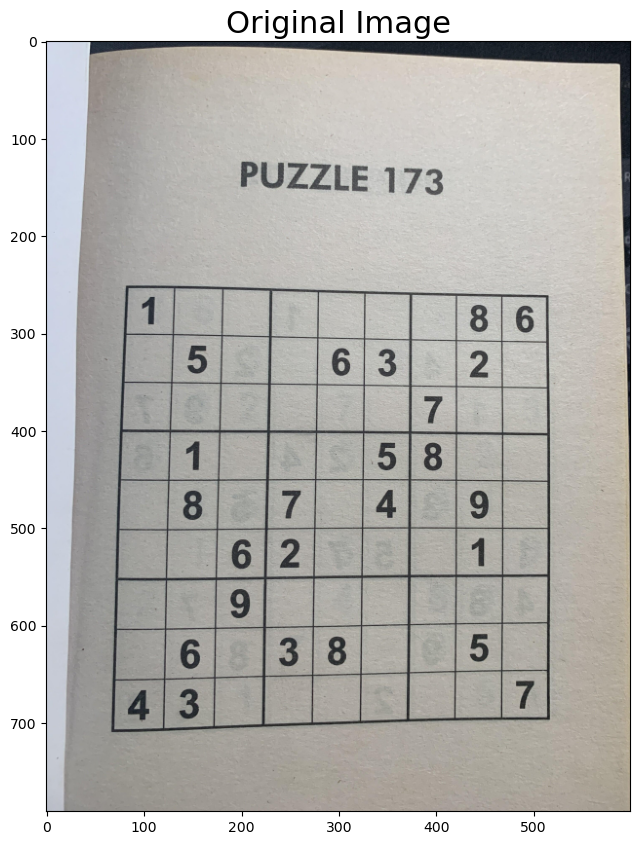

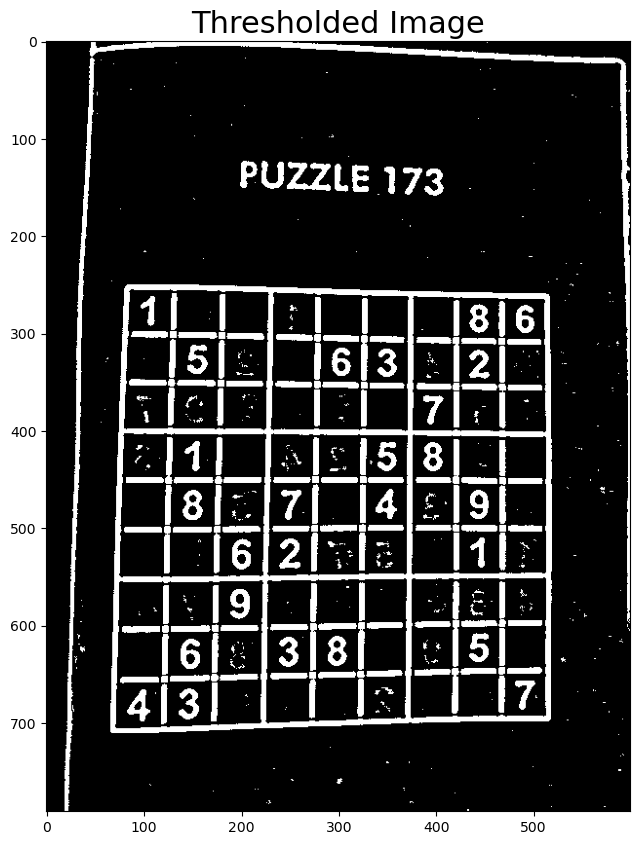

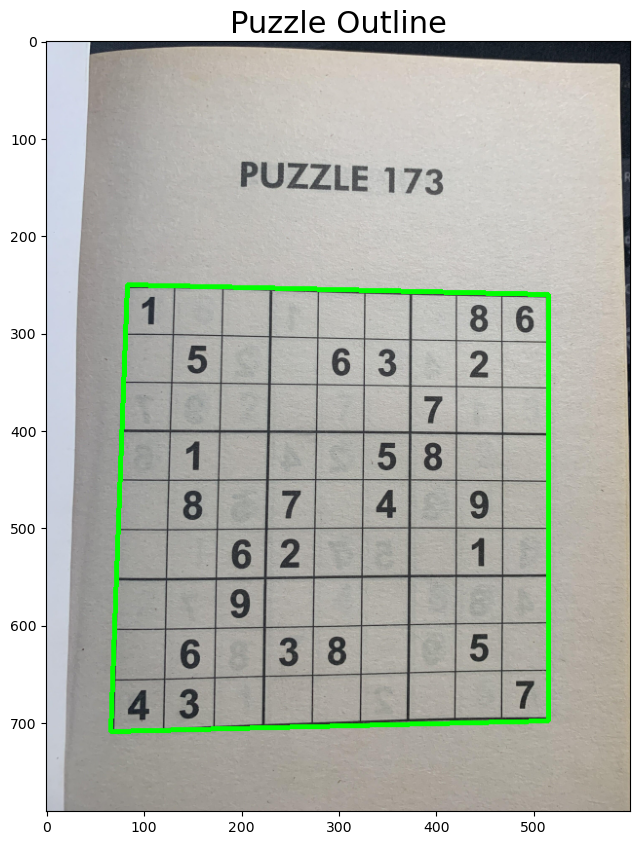

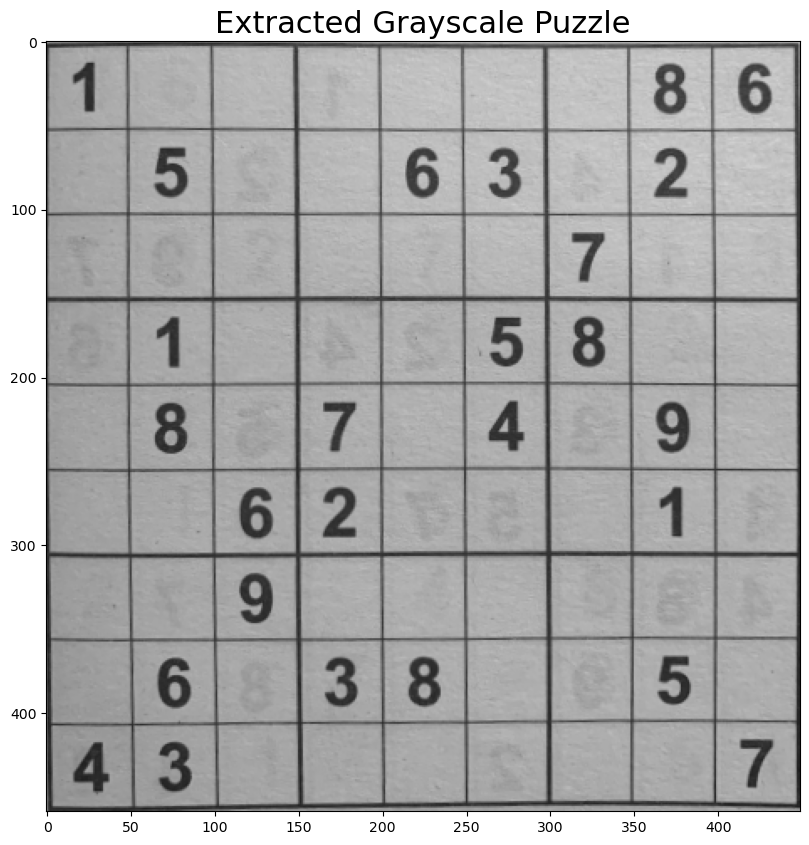

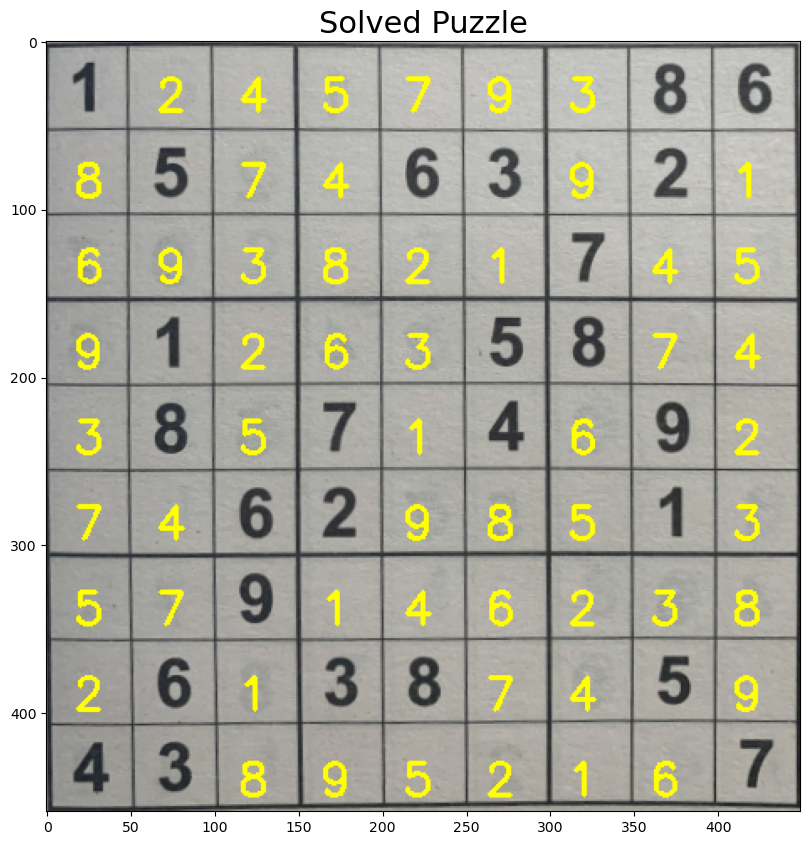

In [10]:
# Main Program Cell

# Load image; second image is sudoku2.jpg
img = cv2.imread('images/sudoku2.jpg')
img = imutils.resize(img, width=600)

# Find puzzle in the image; set debug to False to disable displaying image processing steps
color_puzzle, gray_puzzle = find_puzzle(img, debug=True)

# Initialize sudoku board
unsolved_board = np.zeros((9,9), dtype='int')

# Sudoku is a 9x9 grid (81 individual cells), location of each cell can be inferred by
# dividing the gray_puzzle image into a 9x9 grid
step_x = gray_puzzle.shape[1] // 9
step_y = gray_puzzle.shape[0] // 9

# Load model to detect digits
model = load_model('model_files/digit_classifier_model.h5')

# List of the (x-y) coordinate location of each cell
cell_locs = generate_cell_locations(step_x, step_y)

# Convert board to a list before solving the puzzle
unsolved_board = unsolved_board.tolist()

# Create a deep copy of the unsolved_board to be passed into the solve_puzzle() function
unsolved_board_copy = copy.deepcopy(unsolved_board)

# Note: debug should only be set to True if there are any errors encountered in solving the puzzle. The debug flag helps to identify 
# where the error might be such as puzzle elements not being integers or presence of duplicates in a row, column, 3x3 block. 
# However, it results in a significantly slower performance of the function.
#
# The error checks enabled by the debug flag were also used in unit testing the solve_puzzle() function.

# Solve puzzle
solved_board = solve_puzzle(unsolved_board_copy, debug=False)

# Display puzzle solutions
if not solved_board:
    print('\nPuzzle could not be solved, check training model.\n')
else:
    display_solutions(cell_locs, color_puzzle)